In [1]:
import torch
import org_whisper as whisper
import ast
from pathlib import Path
import pandas as pd

from my_model import Mymodel
from data_utils import MinyoDataset_for_test, MinyoDataset
from for_test import get_test_data, around_pad_seqence
from transformers import WhisperProcessor



In [2]:
processor = WhisperProcessor.from_pretrained("openai/whisper-large-v2", language="ko", task="transcribe", predict_timestamps=True)

In [3]:
pre_model = whisper.load_model("/home/daewoong/userdata/danbi/whisper_pretrain/large-v2.pt", device='cpu')  
model_dims = pre_model.dims
model_dims.n_ref_encoder_layer = 4
model_dims.n_ref_decoder_layer = 4
model_dims.n_ref_text_ctx = 256
model_dims.n_ref_text_state = 1280
model_dims.ref_encoder_type = 'cnn'
checkpoint = torch.load('0615_train/epoch_8.pt', map_location='cpu')
model = Mymodel(model_dims)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [ ]:
# temperature를 설정하지 않으면 0, 0.2, 0.4 ... 1.0 까지 돌면서 inference를 진행합니다.
# test set에서 길이를 넘는건 2개 인 것 같습니다.
test_dataset_mid_csv = get_test_data(model, device = 'cuda', temperature = 0.0)

In [ ]:
test_dataset_mid_csv.to_csv('/home/daewoong/userdata/danbi/train_result/change.csv')

In [4]:
around_txt = '오돌또기 저기 춘향 나온다\n 달도 밝다 제가 버리로 갈까나\n 둥그대당실 둥그대당실 여도당실 연자버리고\n 달도 밝다 제가 머리로 갈까나\n 서귀포 바당에 해녀가 든숭만숭\n 둥그대당실 둥그대당실 여도당실 연자버리고\n 달도 밝다 제가 머리로 갈까나\n 둥그대당실 둥그대당실 여도당실 연자버리고\n 달도 밝다 제가 머리로 갈까나\n'
token_ar = processor.tokenizer(around_txt, return_tensors="pt")

In [9]:
tokens = token_ar.input_ids[0].tolist()
len(tokens), len(set(tokens))

(149, 51)

In [14]:
# read entire lyric to check token distribution

txt_fn = 'each_song_lyrics.txt'
with open(txt_fn, 'r') as f:
  text = f.readlines()

text = ''.join(text)
entire_tokens = processor.tokenizer(text, return_tensors="pt").input_ids

Token indices sequence length is longer than the specified maximum sequence length for this model (1268648 > 1024). Running this sequence through the model will result in indexing errors


In [18]:
len(entire_tokens[0]), len(set(entire_tokens[0].tolist()))

(1268648, 2387)

In [21]:
for i in range(len(tokens)): 
  print(processor.decode(tokens[:i]))


<|startoftranscript|>
<|startoftranscript|><|ko|>
<|startoftranscript|><|ko|><|transcribe|>
<|startoftranscript|><|ko|><|transcribe|>오�
<|startoftranscript|><|ko|><|transcribe|>오�
<|startoftranscript|><|ko|><|transcribe|>오돌�
<|startoftranscript|><|ko|><|transcribe|>오돌�
<|startoftranscript|><|ko|><|transcribe|>오돌또
<|startoftranscript|><|ko|><|transcribe|>오돌또기
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 �
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘향
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘향 나온
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘향 나온다
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘향 나온다

<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘향 나온다
 달�
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘향 나온다
 달도
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘향 나온다
 달도 밝
<|startoftranscript|><|ko|><|transcribe|>오돌또기 저기 춘향 나온다
 달도 밝다
<|startoftranscript|><

'이여도 한양 라 이여도하 한양, 저녁이나 밝으때 하저, 이여방애 이여방애, 이여도 한양 라 이여도 한양 라, 이여이여 이여도 한양 라, 한 마슬에 세첩한 놈은, 대천바당 한 가운데, 이여동 한양 라 이여동 한양 라, 집세거리 이신놈은, 살앙간이나 잇건마는, 이여이여 이여도 한양 라, 사랑 사랑은 내 사랑이여, 이여도 한양 라 이여도 한양 라, 간다드니 웨 왓더냐, 돌아사면 후훼 할 질을, 돌아 사지를 말 아니해여 말 아니 해여, 한 해에랑 옷 세벌 입엉, 보리 비단 능라비로, 즉을때 까장 사랑한다고 해여두고, 한강 바당 한가운 듸랑, 치엇은 배질이러라\n'

In [ ]:
t, b = around_pad_seqence(token_ar)

In [ ]:
import IPython.display as ipd

audio_fn = '/home/daewoong/userdata/danbi/final_tts_audio/lyric36-5.wav'
ipd.Audio(audio_fn)

In [ ]:
#달도 밝다 제가 머리로 갈까나 서귀포 바당에 해녀가 든숭만숭
#{'text': ' 달도 밝다 제가 머리로 갈까나 서귀포 바당에 해녀가 든숭만숭빠큰',

model.eval()
model.to('cuda')
with torch.no_grad():
  out = model.transcribe(audio ='/home/daewoong/userdata/danbi/final_tts_audio/lyric36-5.wav', around_text=t.unsqueeze(0).cuda())

In [ ]:
# 저장 할 주소 입력하면 됩니다.
# 현재 오리지널 위스퍼의 결과값은 /home/daewoong/userdata/danbi/csv_list/org_whisper_pred.csv 에 저장되어있습니다.
#test_dataset_mid_csv.to_csv('/home/daewoong/userdata/danbi/csv_list/3-3_val_best_wer3_temp_all.csv')
test_dataset_mid_csv.to_csv('/home/daewoong/userdata/danbi/train_result/val_best_wer_6.csv')

In [ ]:
test_dataset_mid_csv['org_whisper_pred'] = org_whisper['org_whisper_pred']
test_dataset_mid_csv['org_whisper_wer'] = org_whisper['org_whisper_wer'].round(2)
test_dataset_mid_csv['org_whisper_cer'] = org_whisper['org_whisper_cer'].round(2)


In [ ]:
test_dataset_mid_csv['diff'] = (test_dataset_mid_csv['org_whisper_cer'] - test_dataset_mid_csv['pred_cer']).round(2)

In [ ]:
test_dataset_mid_csv

In [4]:
import pickle
audio_path = '/home/daewoong/userdata/danbi/final_tts_audio'
lyric_path = '/home/daewoong/userdata/danbi/final_lyrics_data/'
each_lyric = '/home/daewoong/userdata/danbi/each_song_lyrics.txt'
result_path = '/home/daewoong/userdata/danbi/encoder_result'
filtered_id_list = pickle.load(open('/home/daewoong/userdata/danbi/thirty_second_filtered_id.pkl', 'rb'))

processor = WhisperProcessor.from_pretrained("openai/whisper-large-v2", language="ko", task="transcribe", predict_timestamps=True)


dataset = MinyoDataset_for_test(result_path, lyric_path, processor, filtered_id_list, each_lyric, max_len = 1024, random_ratio=0)
#dataset = MinyoDataset(result_path, lyric_path, processor, filtered_id_list, each_lyric, max_len = 1024, random_ratio=0)


In [75]:
from tqdm.auto import tqdm
def read_text(txt_path):
  with open(txt_path, 'r') as f:
    text = f.read()
  return text
each_lyric_list = read_text(each_lyric).split('\n')

split_lyric = [] 
for i in each_lyric_list:
  txt = ('\n '.join(i.split(', ')))
  txt += '\n'
  split_lyric.append(txt)

token_len_list = []
for i in tqdm(range(len(split_lyric))):
  token_len_list.append(len(processor.tokenizer.encode(split_lyric[i])))
  

  0%|          | 0/7679 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1034 > 1024). Running this sequence through the model will result in indexing errors


In [118]:
j = 0
for i in token_len_list :
  if i > 1024:
    j += 1

In [120]:
j

65

<Figure size 1440x720 with 0 Axes>

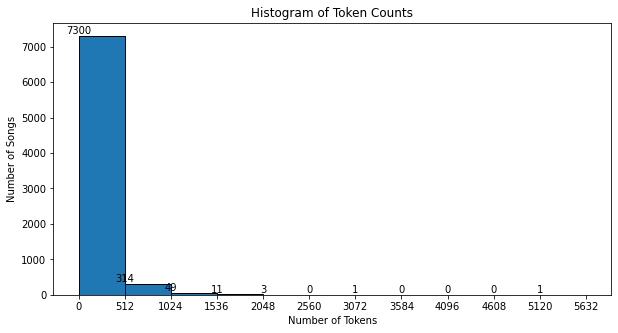

In [121]:
import matplotlib.pyplot as plt
import numpy as np
song_indices = range(len(token_len_list))
plt.figure(figsize=(20,10))  # you can adjust this size as needed
bins = np.arange(0, max(token_len_list) + 512, 512)

plt.figure(figsize=(10,5))  # adjust this size as needed
hist, _, _ = plt.hist(token_len_list, bins=bins, edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Songs')
plt.xticks(np.arange(0, max(token_len_list) + 512, 512))  # set x-ticks to be every 512 units

plt.title('Histogram of Token Counts')
for i in range(len(hist)):
    count = int(hist[i])
    plt.text(bins[i], count, str(count), ha='center', va='bottom')

plt.show()

In [108]:
bins

array([   0,  500, 1024, 1024, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
       5500])

In [46]:
each_lyric_list[0]

'이여도 한양 라 이여도하 한양, 저녁이나 밝으때 하저, 이여방애 이여방애, 이여도 한양 라 이여도 한양 라, 이여이여 이여도 한양 라, 한 마슬에 세첩한 놈은, 대천바당 한 가운데, 이여동 한양 라 이여동 한양 라, 집세거리 이신놈은, 살앙간이나 잇건마는, 이여이여 이여도 한양 라, 사랑 사랑은 내 사랑이여, 이여도 한양 라 이여도 한양 라, 간다드니 웨 왓더냐, 돌아사면 후훼 할 질을, 돌아 사지를 말 아니해여 말 아니 해여, 한 해에랑 옷 세벌 입엉, 보리 비단 능라비로, 즉을때 까장 사랑한다고 해여두고, 한강 바당 한가운 듸랑, 치엇은 배질이러라'

In [13]:
tt = '이여도 한양 라 이여도하 한양\n 저녁이나 밝으때 하저\n'
print(processor.tokenizer.encode(tt))
tt = '이여도 한양 라 이여도하 한양\n저녁이나 밝으때 하저'
print(processor.tokenizer.encode(tt))

[50258, 50264, 50359, 21064, 1698, 1838, 4815, 14973, 22339, 4329, 245, 1698, 1838, 2240, 4815, 14973, 198, 13163, 227, 223, 21672, 26499, 3336, 14922, 3369, 11738, 198, 50257]
[50258, 50264, 50359, 21064, 1698, 1838, 4815, 14973, 22339, 4329, 245, 1698, 1838, 2240, 4815, 14973, 198, 2179, 2366, 227, 223, 21672, 26499, 3336, 14922, 3369, 11738, 50257]


In [52]:
processor.decode([21064, 1698, 1838, 4815, 14973, 22339, 4329, 245, 1698, 1838, 2240, 4815, 14973, 198, 2179, 2366])

'이여도 한양 라 이여도하 한양\n저�'

In [43]:
processor.decode([21064, 1698, 1838, 4815, 14973, 22339, 4329, 245, 1698, 1838, 2240, 4815, 14973, 198, 2179,])

'이여도 한양 라 이여도하 한양\n�'

In [ ]:
dataset = MinyoDataset(result_path, lyric_path, processor, filtered_id_list, each_lyric, max_len = 1024, random_ratio=0)


In [ ]:
audio_encoder_value, input_text, input_text_attn, around_text_ids, around_text_mask = dataset[0]

In [ ]:
processor.tokenizer.decode(around_text_ids)

In [ ]:
a,b,c,d = dataset[0]

In [ ]:
d

In [ ]:
from tqdm.auto import tqdm
for i in tqdm(range(len(dataset))):
  _,_,_,d = dataset[i]
  if d.split('-')[0] == 'lyric3696':
    print(i)

In [ ]:
dataset[0], dataset[7151]

In [ ]:
dataset[0]

In [ ]:
import pandas as pd
test_dataset_mid = pd.read_csv('/home/daewoong/userdata/test_set/test_dataset_mid.csv')
around_text = '\n'.join(ast.literal_eval(test_dataset_mid.iloc[0]['total_lyric']))

In [ ]:
around_text